<a href="https://colab.research.google.com/github/vidisha04/02467-CSS/blob/main/Assignment_2Collected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\textbf{GitHub:}$\
https://github.com/vidisha04/02467-CSS.git

$\textbf{Group Members:}$
- Mads Andersen: s204137
- Marton Kohegyi: s230086
- Vidisha Sinha: s204081

$\textbf{Contribution Statement:}$\
We have worked on all parts together, but the main responsibility for adding the code and descriptions for Parts 1, 2, and 3 was taken by Mads, Marton, and Vidisha respectively.

In [1]:
import networkx as nx
import numpy as np 
import pandas as pd
import json
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt 
import os
import pickle
import copy 
import random
import seaborn as sns 
from scipy.stats import pearsonr,ttest_1samp

### Part 1
Exercise 1: Mixing Patterns and Assortativity.

Overview of the tasks: 
* For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.
* Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.
* Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?
* Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (Hint: See this paper, eq (2)). Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.
* Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.
* Optional: Estimate the gender of each author from their name, using the World Gender Name Dictionary. Repeat the analysis above to study the assortativity of the network by gender rather than by field. What do you observe? 

Start out by reading in the graph from week 4, from the json file.

In [2]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [3]:
#Only if you use colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
G = read_json_file('/content/gdrive/MyDrive/Computational Social Science/graph.json')
print(G)

Graph with 4640 nodes and 9376 edges


Exctracting the giant connected component from the graph.

In [5]:
s = max(nx.connected_components(G), key=len)
G = G.subgraph(s)

### Calculating the fraction of edges to same subfield
For this exercise the fractions of edges connecting to nodes with the same top-field is calculated. This is done by iterating through the nodes in the graph, then for each of the nodes a value is stored in a dictionary, such that the mean value of the fractions can be computed later on. 

In [6]:
def calc_fraction(G): 
  fractions = {}
  for id in G.nodes:
    field = G.nodes[id]['field']
    same_top_field = 0
    n_neighbours = 0
    for neighbour_id in G.neighbors(id):
      neighbour = G.nodes[neighbour_id]
      if neighbour['field'] == field:
        same_top_field += 1
    
      n_neighbours += 1
    fractions[id] = same_top_field/n_neighbours if len(list(G.neighbors(id))) != 0 else 0

  return fractions

Compute the average of the fractions, from the dictionary which is created in the function defined above. 

In [7]:
fractions = calc_fraction(G)
n = sum(fractions.values())/len(fractions.values())
t = f'Average fraction of nodes connecting to another with the same field: \n{n}'
print(t)

Average fraction of nodes connecting to another with the same field: 
0.5136100357093106


### Random shuffeling fields
Now we will random shuffle the fields between the nodes. This is done, by simply creating a list of the fields in the graph, and then by random selecting a field for a given node. For this exercise it is important that the probabillity of having a certain field is still preserved, especilly because the top-fields had to be randomly shuffled between nodes. This is solved by randomly selecting a field, from the entire fields list **without** replacement.  

In [8]:
# Get the list of fields in the original graph
np.random.seed(0)
def random_shuffle_fields(G):
  fields = list(nx.get_node_attributes(G, 'field').values())
  #fields = fields[1:] # First is nan for some reason
  measure_shuffled = []

  # Create a new graph with the same nodes and edges as the original graph,
  # but with the fields shuffled
  G_shuffled = copy.deepcopy(G)
  for node in G_shuffled.nodes:
      #rand_idx = random.randint(0,len(fields)-1)
      G_shuffled.nodes[node]['field'] = np.random.choice(fields,replace=False)

  # Compute the measure for the shuffled graph
  fractions = calc_fraction(G_shuffled)
  measure_shuffled = sum(fractions.values())/len(fractions.values())

  #print(f"The measure for the shuffled graph is: {measure_shuffled}")
  return measure_shuffled

Now the function can be called on the graph ```G```

In [9]:
random_shuffle_fields(G)

0.3564545460445377

So this is quite a lot lower than what that what was seen before, hower since the number is based on random selection the function can be called multiple times to give a more robust estimate. 

### Repeating the same thing 150 times
Now the function can be called 150 times, since it gives a more robust estimate, it was chosen to run the random shuffle, a bit more than the minimum requirement. 

In [10]:
meassures = []
for i in range(150):
  meassures.append(random_shuffle_fields(G))

Now the distribution will be plottet, and what can be seen from the plot is that it looks rather normal distributed, but with really low values, and it definitly looks like it is significantly different than the 0.3 that was observed when computing for the original graph. 

Text(0.5, 0, 'Fraction Meassures')

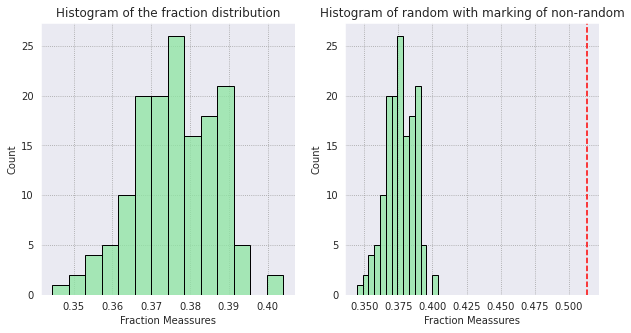

In [11]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig,ax = plt.subplots(1,2,figsize = (10,5))
# Hist
sns.histplot(meassures, bins = 14, ax = ax[0],edgecolor = "black",color = '#8de5a1')
ax[0].set_title("Histogram of the fraction distribution")
ax[0].set_xlabel("Fraction Meassures")
#Comparison 
sns.histplot(meassures, bins = 14, ax = ax[1],edgecolor = "black",color = '#8de5a1')
ax[1].axvline(n, color="r", linestyle="--")
ax[1].set_title("Histogram of random with marking of non-random")
ax[1].set_xlabel("Fraction Meassures")

As can be seen the two values are quite far appart, and thus a conclusion would be that it is not coencidental that the nodes with the same topfield, are often connected together. However to be a bit more rigourus in the approach to testing this, one can compute a 1samp ttest, in which it is tested if the mean value computed for the real graph is the mean value for the random graph. This wil then assume that the true mean, is the one from the css-graph. Furthermore since it is a distribution of means, the central limit theorem applies, and a normal distribution can be assumed.  

In [12]:
ttest_1samp(meassures,popmean = n)

TtestResult(statistic=-158.55715130803125, pvalue=5.0047144021625e-168, df=149)

So from these results the H0 of equal means, is rejected with $\alpha = 0.05$. Confirming the intution from the plot, that the connection between authors with the same fields, are significantly different than if their fields had been randomly assigned. 

---

#### Computing the assortativity coefficient 
In order to implement the coefficient the formula from *(Newman,2003)*: 

$$r=\frac{\sum_i e_{i i}-\sum_i a_i b_i}{1-\sum_i a_i b_i}=\frac{\operatorname{Tr}\mathbf{e}-\left\|\mathbf{e}^2\right\|}{1-\left\|\mathbf{e}^2\right\|}$$

Where Tr denotes the trace of the matrix. 
First the e matrix will be computet which is the fraction how many times a node with one field connects with another. Do note that some of the fields are ```nan``` values, however it was discussed that these nodes could still be usfull for interpreting how the network connects. 

In the code below, the counting matrix has been implemented for both the categorical and degree, since the degree will be used later, this was done in order to collect the very similar functions, and hopefully make it more readable.

In [13]:
def e_matrix(G,att):
  """ 
  Calculate the attribute "E" matrix for a networkx graph G, where att denotes a selected attribute to calculate it on. 
  """
  #Get the fields
  fields = list(set(nx.get_node_attributes(G, att).values()))

  #Smart index trick
  category_indices = {fields: i for i, fields in enumerate(fields)}

  # Loop Through and and increment the correct indicies
  N = len(fields)
  e = np.zeros((N, N))
  for u, v in G.edges():
      i = category_indices[G.nodes[u][att]]
      j = category_indices[G.nodes[v][att]]
      e[i, j] += 0.5
      e[j, i] += 0.5

  norm_coef = G.number_of_edges() # To do some standardization of the matrix 
  e = e/norm_coef
  return e

#calcutlate the coefficient for the the graph. 
def get_assortativity_coefficient(G,att,cat = True):
  e = e_matrix(G,att) # Get matrix
  return (np.trace(e) - np.sum(np.sum(e, axis=0)**2))/(1-np.sum(np.sum(e, axis=0)**2))

In [14]:
get_assortativity_coefficient(G,'field')

0.14471860156236604

Test the implementation, with the nx implementation. Quite close to the answer so, so the implementation above should be correct. 

In [15]:
nx.attribute_assortativity_coefficient(G,'field')

0.1447186015623658

From this metric, it can be concluded that the graph is moderatly assortative with respect to the topfield, since it is slightly positive. This in terms mean that authors with the same top-field do tend to connect to eachother more than they would randomly, however not in a very strong manner. What can be interpreted for these results, is that computational social scientist tends to work fairl

#### Assortivity with respect to degree

For this part the assortivity coeficient will be calculated with respect to the degree of the nodes, and it will be discussed weather highly connected authors tend to connect with other highly connected authors. According to *(Newman,2003)* this would be equivalent to finding the pearson correlation between the degrees of the edges. This is also the approach that was followed in this exercise. First the x,y coordinates are found, such that x has the degree of on node and y the degree of a connecting node. However the datapoint (y,x) is also added, since the graph is undirected. This way will also allow for plotting the points, which will then also reveal if the correlation might be non-linear.

In [16]:
def get_xy_vals(G):
  """ 
  This function will create a datapoint for each pair in the graph
  with their respective degrees as value.
  G: Networkx graph
  """
  x,y = [],[]
  for edge in G.edges():
    X_deg = G.degree(edge[0])
    Y_deg = G.degree(edge[1])
    x.append(X_deg)
    y.append(Y_deg)
    y.append(X_deg)
    x.append(Y_deg)
    
  return x,y 
x,y = get_xy_vals(G)

Test the results with the pearson correlation calculated by using the ```scipy.stats``` module, and check if the results are consistent with the networkx implementation. 

In [17]:
pearsonr(x,y)

PearsonRResult(statistic=-0.011556789318338659, pvalue=0.13627090173424145)

Testing if the implementation is correct: 

In [18]:
nx.degree_assortativity_coefficient(G)

-0.011556789318338603

So the implementation is consistent with the networkx implementation. From this number however, it can be concluded that the graph is not really assortative with respect to degree, however it also slightly negativly assortative, however so vagualy that it is more up to chance if a node connects to a very well connected node or a weakly connected node. 

Now the datapoints can be plotted, in the x,y plane, in order to give a better insight into how they are connected. 

<ipython-input-19-dbe1dad5d453>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = x,y = y,palette="deep",marker=".", color = 'darkred')


Text(0, 0.5, 'Degree')

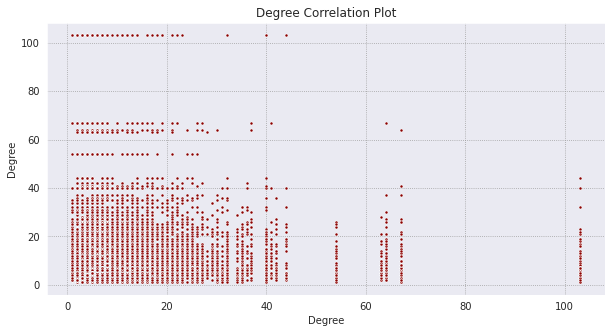

In [19]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax,fig = plt.subplots(1,figsize = (10,5))
sns.scatterplot(x = x,y = y,palette="deep",marker=".", color = 'darkred')
plt.title("Degree Correlation Plot")
plt.xlabel("Degree")
plt.ylabel("Degree")

From these results two things are are clear first of the pearson correlation did not prove to be significantly different from zero, which also means that the graph does not seem to be assortative with respect to the degree of the nodes. From the plot however it is also quite apparent that no real correlation between degrees of nodes exists. One interesting thing the plot reveals however, is the fact that most of the degrees are in the lower range, while only a few is having a lot of outgoing degrees. 

#### Estimating gender of each author from their name *(optional)*

For this optional task, the gender can be found using the world gender name dictionary, which can be loaded into the nodebook using the gender_guesser library, which is build on a data-base quite similar to the World Gender Name Dictionary, so in order to avoid downloading the entire file, this library is used. It only works on the first name, so for this exercise it will be assumed that the first "word" in the name is their first name.  

In [20]:
!pip install gender_guesser # Install the package 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 KB 6.6 MB/s eta 0:00:00


In [21]:
import gender_guesser.detector as gender # Import the detector

First iterate the graph, get the gender then create a new field in the graph called "Gender". One thing to take into account is the fact that the function ```get_gener```will return unknown if the name does not exist in the database. 

In [22]:
d = gender.Detector()
# Now loop through 
for node in G.nodes():
  auth_name = G.nodes[node]['name'].split(' ')[0]
  g = d.get_gender(auth_name)
  G.nodes[node]['Gender'] = g

Get the assortivity coeficient with respect to the gender. 

In [23]:
get_assortativity_coefficient(G,'Gender')

0.08357252652313847

So this would suggest that most of the computational social scientists in the graph does not really connect to any kind of gender, and it is mostly random who they connect with *(with respect to gender of course)*. All in all the network of computational social scientists does not seem to have any bias, regarding the gender of who they work with.

### Part 2: Communities

#### Exercise 2: Zachary's karate club: In this exercise, we will work on Zarachy's karate club graph.

The dataset is available in NetworkX, by calling the function karate_club_graph

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
#import netwulf as wulf
import random
from networkx.algorithms import community
from community import community_louvain
from tabulate import tabulate
import json
import jsonpickle
from networkx.readwrite import json_graph

In [ ]:
#creating the graph
G = nx.karate_club_graph()

1. Visualize the graph using netwulf. Set the color of each node based on the club split (the information is stored as a node attribute).

In [ ]:
#prepare the dataset, label each node to store color information for the visualization
belonging = nx.get_node_attributes(G, 'club')

ColorArray =[]
partition_prep = [[],[]]

for i in belonging:
    if belonging[i] == "Mr. Hi":
        ColorArray.append("#606060FF")
        partition_prep[0].append(i)
    else:
        ColorArray.append("#D6ED17FF")
        partition_prep[1].append(i)


dictionaryColor = dict(zip(list(G.nodes), ColorArray))
nx.set_node_attributes(G, dictionaryColor,"color")

In [ ]:
#create custom configuration for netwulf, so it is immediatelly nice after we run it
custom_config = {
    "zoom": 1.09320127948937,
    "node_charge": -100,
    "node_gravity": 0.02906058760349766,
    "link_distance": 50,
    "link_distance_variation": 0,
    "node_collision": False,
    "wiggle_nodes": False,
    "freeze_nodes": False,
    "node_fill_color": "#79aaa0",
    "node_stroke_color": "#555555",
    "node_label_color": "#000000",
    "node_size": 6.64244264770301,
    "node_stroke_width": 1.0171237334889143,
    "node_size_variation": 0.5,
    "display_node_labels": False,
    "scale_node_size_by_strength": False,
    "link_color": "#7c7c7c",
    "link_width": 3.9941371000922654,
    "link_alpha": 0.4026983428655228,
    "link_width_variation": 0.6,
    "display_singleton_nodes": True,
    "min_link_weight_percentile": 0,
    "max_link_weight_percentile": 1
}

In [ ]:
#visualizing using netwulf
wulf.visualize(G, config = custom_config, plot_in_cell_below=False)

![title](https://github.com/vidisha04/02467-CSS/blob/main/img/netwulf.png?raw=1)

2. Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [ ]:
#helper method to calculate degree of a graph
def get_total_degree(G):
    sum = 0
    for i in range(G.number_of_nodes()):
        sum += G.degree(list(G)[i])
    return sum

The modularity is calculated as: <br>
$Q = \sum_{c=1}^{n}
       \left[ \frac{L_c}{m} - \gamma\left( \frac{k_c}{2m} \right) ^2 \right]$
<br>where
- L_c is the number of links within community c
- m is the total number of connections in the graph
- k_c is the total degree of each community c
- $\gamma$ is the resolution parameter (in this case 1)

In [ ]:
def Modularity(G,  p):
    mod = 0.0
    L = G.number_of_edges()
    for i in range(len(p)):
        tmp = G.subgraph(p[i])
        L_c = tmp.number_of_edges()
        k_c = get_total_degree(tmp)
        mod += ((L_c/L) - pow((k_c/(2*L)),2))
    return mod

3. Explain in your own words the concept of modularity.
<br>

Modularity helps to gain an idea about how well-partitioned a graph is to communities.
It compares the inner edges of each group with all of the edges.
It shows how well the communitie's nodes are connected to each other, as opposed to the whole network.

4. Compute the modularity of the Karate club split partitioning using the function you just wrote.

In [ ]:
actualModularity = Modularity(G, partition_prep)
print("Modularity of the club split in Zachary's karate club: "+str(actualModularity))

Modularity of the club split in Zachary's karate club: 0.48931623931623935


5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from 0. To do so, we will implement the double edge swap algorithm.

In [ ]:
#copying graph
G_copy = nx.Graph(G)

In [ ]:
#implementing double edge swap based on the description of the task
def double_edge_swap(G):
    n = 0
    swapcount = 0
    degrees = get_total_degree(G)
    edge_list = list(G.edges)
    while swapcount < G.number_of_edges()+2: #number of edges+2 is just a choice of mine, it could be anything
        r1 = random.randint(0,len(edge_list)-1) #picking 2 random edges
        r2 = random.randint(0,len(edge_list)-1)
        uv = edge_list[r1]
        xy = edge_list[r2]
        if (uv[0] == xy[0]) or (uv[0] == xy[1]): #if the 2 edges suitable, swap them
            continue
        if (uv[1] == xy[0]) or (uv[1] == xy[1]):
            continue
        if (edge_list.__contains__((uv[0],xy[0])) == False) and (edge_list.__contains__((uv[1],xy[1])) == False):
            if (edge_list.__contains__((xy[0],uv[0])) == False) and (edge_list.__contains__((xy[1],uv[1])) == False):
                G.add_edge(uv[0],xy[0])
                G.add_edge(uv[1],xy[1])
                G.remove_edge(uv[0],uv[1])
                G.remove_edge(xy[0],xy[1])
                edge_list = list(G.edges)
                swapcount += 1
    #print(str(swapcount) + " swaps are done.")
    

6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [ ]:
swapped = double_edge_swap(G_copy)

In [ ]:
print("Degree of original graph: "+ str(get_total_degree(G_copy)))
print("Degree of swapped graph: "+ str(get_total_degree(swapped)))

7. Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list

In [ ]:
#creating 1000 swapped graphs
modularityList = []
for i in range(1000):
    G_copy = nx.Graph(G)
    double_edge_swap(G_copy)
    modularityList.append(Modularity(G_copy, partition_prep))

8. Compute the average and standard deviation of the modularity for the random network.

In [ ]:
print("Average of the modularities: "+str(sum(modularityList) / len(modularityList)))

Average of the modularities: 0.3922899408284019


In [ ]:
print("Standard deviation of the modularities: "+str(np.std(modularityList)))

Standard deviation of the modularities: 0.021707825405475323


9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use axvline).

In [ ]:
#helper for the chart
min(modularityList), max(modularityList)

(0.33284023668639057, 0.4478961209730441)

Text(0.455, 150, '  Original\nmodularity')

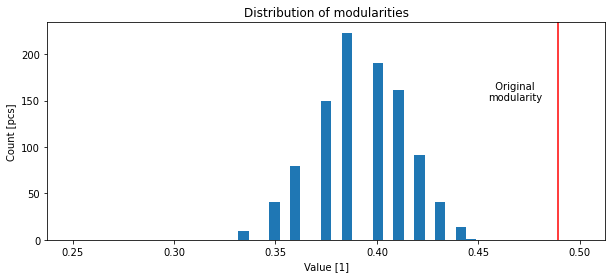

In [ ]:
#create bins and histogram data
bins = np.linspace(0.25,0.5,50)
hist, edges = np.histogram(modularityList,bins=bins)
x = (edges[1:]+edges[:-1])/2
width = bins[1]-bins[0]

#create plot
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Distribution of modularities")
ax.set_xlabel("Value [1]")
ax.set_ylabel("Count [pcs]")
ax.bar(x,hist,width=width)
#plt.xlim([0.25,0.5])
ax.axvline(actualModularity, c='r')
plt.text(0.455,150,'  Original\nmodularity')

10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

- As the club split's modularity is much higher than the average, it should be considered as a good partitioning.
- I think the randomization helped to contrast the original groups to randomly created ones.
- The nodes' degree is highly involved in the computing of modularity, so it must be preserved if we want to draw conclusions.

11. Use the Python Louvain-algorithm implementation to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [ ]:
#finding communities
louvainPartition_tmp = community_louvain.best_partition(G)

In [ ]:
#formatting to have similar datasets
louvainPartition = []
nogroups = 0
for i in range(len(louvainPartition_tmp)):
    if louvainPartition_tmp[i]>= nogroups:
        nogroups = louvainPartition_tmp[i]
for i in range(nogroups+1):
    louvainPartition.append([])
for i in range(len(louvainPartition_tmp)):
    louvainPartition[louvainPartition_tmp[i]].append(i)

In [ ]:
louvainPartition

[[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33],
 [23, 24, 25, 27, 28, 31],
 [4, 5, 6, 10, 16]]

In [ ]:
partition_prep

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]

In [ ]:
print("Modularity with the found communities: " + str(Modularity(G, louvainPartition)))
print("Modularity of the club split: " + str(actualModularity))

Modularity with the found communities: 0.5573635765943459
Modularity of the club split: 0.48931623931623935


The modularity is higher, which shows that the club split is not the most accurate division of the group.<br>
In fact this suggests, that we could split these 2 groups into even smaller communities, which will result in a higher modularity number.

12. Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix D with dimension (2 times A), where A is the number of communities found by Louvain. We set entry D(i,j) to be the number of nodes that community i has in common with group split j. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [ ]:
#creating confusion matrix
data = [["","Louvain group 1", "Louvain group 2","Louvain group 3","Louvain group 4"],
        ["Club group 1", len(set(louvainPartition[0]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[0]).intersection(set(partition_prep[1]))),
        len(set(louvainPartition[1]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[1]).intersection(set(partition_prep[1])))],
        ["Club group 2", len(set(louvainPartition[2]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[2]).intersection(set(partition_prep[1]))),
        len(set(louvainPartition[3]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[3]).intersection(set(partition_prep[1])))]]

In [ ]:
print(tabulate(data, tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╕
│              │ Louvain group 1 │ Louvain group 2 │ Louvain group 3 │ Louvain group 4 │
├──────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Club group 1 │ 11              │ 0               │ 1               │ 11              │
├──────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Club group 2 │ 0               │ 6               │ 5               │ 0               │
╘══════════════╧═════════════════╧═════════════════╧═════════════════╧═════════════════╛


The takeaway here is that since almost all nodes of the Louvain groups are either from the club split 1 or 2 (only one exception to this), <br>
the Louvain groups represent a similar community division as the original, it just consits of 2 extra groups.<br>
Adding group 1-3 and 2-4 together would almost result in the same groups.

#### Exercise 3: Community detection on the network of Computational Social Scientists.

13. Consider the network you built in Week 4. <br>
Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?

In [ ]:
#Only if you use colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Load the JSON file
with open('/content/gdrive/MyDrive/Computational Social Science/graph.json') as f: # I inserted my own path //Mads
    data = json.load(f)

# Create a new NetworkX graph
G_CSS = nx.Graph()

# Add nodes to the graph
for node in data['nodes']:
    G_CSS.add_node(node['id'], name=node['name'], field=node['field'], median_cit_count=node['median_cit_count'], first_paper=node['first_paper'])

# Add edges to the graph
for edge in data['links']:
    G_CSS.add_edge(edge['source'], edge['target'], weight=edge['weight'])

In [ ]:
louvainPartition_CSS = community_louvain.best_partition(G_CSS)

In [ ]:
all_comms = max(louvainPartition_CSS.values())
print("Communities found: " + str(all_comms))

Communities found: 871


In [ ]:
#convert dict to a more managable format for myself
louvainPartition = []
for i in range(all_comms + 1):
    louvainPartition.append([])
for node_id, group_id in louvainPartition_CSS.items():
    louvainPartition[group_id].append(node_id)

Showing a few examples of the sizes of communities:

In [ ]:
for i in range(30):
    print(len(louvainPartition[i]), end =", ")

11, 1, 162, 1, 202, 167, 160, 90, 80, 111, 1, 2, 1, 60, 308, 2, 144, 1, 87, 9, 89, 132, 78, 84, 33, 227, 2, 1, 14, 72, 

In [ ]:
#computing modularity
community_louvain.modularity(louvainPartition_CSS, G_CSS)

0.8807767793327977

Yes, the modularity is fairly close to 1, that means the division is good. <br>Since this is the purpose of the algorithm (to create a division which represents groups), this was expected.

14. If you are curious, you can also try the Infomap algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm.

In [ ]:
!pip install infomap # Install the package in the colab env. 

In [ ]:
from infomap import Infomap

In [ ]:
#detecting communities using infomap
im = Infomap(silent=False,num_trials=100,seed=123)
map = im.add_networkx_graph(G_CSS)
im.run()

In [ ]:
print(f"Found {im.num_top_modules} modules")

Found 847 modules


This algorithm found almost the same amount of communities.

In [ ]:
# Switch out the keys witht the mapping keys
inf_map = im.get_modules()
new_partition = {map[key]: inf_map[key] for key in inf_map.keys()}

The modularity with the infomap algorithm:

In [ ]:
community_louvain.modularity(new_partition, G_CSS)

0.8701706539786521

In conclusion this method found nearly identical communities, and the modularities are similar.<br>
It appears that for this particular case both algorithms creates very similar results, so probably it would be best to use the more cost efficient one.

15. Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their community. Describe the structure you observe. <br>
Make sure you save the assignment of authors to communities.

In [ ]:
mydict = louvainPartition_CSS

In [ ]:
ColorArray =[]

#generating a color for each community
for key in mydict:
    value = mydict[key]
    hexcode = str('#%03X%03X' % (value,value))
    ColorArray.append(hexcode)
    
dictionaryColor = dict(zip(list(G_CSS.nodes), ColorArray))
nx.set_node_attributes(G_CSS, dictionaryColor,"color")

In [ ]:
#visualizing using netwulf
wulf.visualize(G_CSS, plot_in_cell_below=False)

- The densely connected inner part is dominated by a few (approximately 7-8) groups, while there are a lot of single nodes towards the perimeter.
- I think it could help, if we filtered out the single nodes.

![title](https://github.com/vidisha04/02467-CSS/blob/main/img/css_vis.png?raw=1)

# Part 3

In [ ]:
import pandas as pd
import ast
import numpy as np
import nltk
from nltk.probability import FreqDist
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [ ]:
af = pd.read_csv('author_degrees_final.csv')

In [ ]:
tf = pd.read_csv('tokenized_abstracts.csv')
tf['authorIds'] = tf['authorIds'].apply(ast.literal_eval)
tf['tokens'] = tf['tokens'].apply(ast.literal_eval)

# Part 3
## 4.0 Brief overview of prerequisite datasets

There are 2 datasets required for this exercise. The first dataset **af** assigns each author to their network community and has information on the degree of each author. This has been stored as a single Pandas dataframe of size $(4640 \times 3)$. **networkx** and **community** libraries were used to create the *degree* (author degrees) and *comm_ind* (community index) columns respectively.

The second dataset **tf** has abstracts from CSS papers with their *paperId*s,  *authorIds*, *abstract*s, and *tokens*. The tokens are presented as a list and have been checked for punctuations, URLs, stop words, numbers, and case (they are in lower case). The shape of this dataframe is $(9356\times 4)$. The tokens were build using the **ntlk** library.

In [ ]:
print(f'Shape of af: {af.shape}')
af.head()

Shape of af: (4640, 3)


,authorID,degree,comm_ind
0,1699751,4,36
1,1807928,0,457
2,1690967,6,35
3,1728881,6,1
4,1432678629,0,458


In [ ]:
print(f'Shape of tf: {tf.shape}')
tf.head()

Shape of tf: (9356, 4)


,paperId,authorIds,abstract,tokens
0,843f972bd9688a3c26798c93fed09f070ca79c8b,"[1746214, 2833225, 1699751, 1778110, 41224057]",In this work we ask the question: what are the...,"[work, ask, question, challenges, managing, ph..."
1,4af26bf68b04308cae8825cdfa2db3679a8588bd,[144913176],This neat piece of work emphasizes once more t...,"[neat, piece, work, emphasizes, need, engineer..."
2,b8c007761f5928ec2163258a70efe776bf511ef9,[144913176],"This paper will focus on online crime, which h...","[paper, focus, online, crime, taken, serious, ..."
3,e2c07e9d3ddf35f78fca587e7e195b1032adbbe3,[1692837],Audio guides are a common way to provide museu...,"[audio, guides, common, way, provide, museum, ..."
4,e9408bec58e4820c474941eec2db2a0bf08ae747,"[1733733, 1807928]",This paper presents a system for keyword detec...,"[paper, presents, system, keyword, detection, ..."


## 4.1 Explaining TF-IDF
TF-IDF or Term Frequency-Inverse Document Frequency is a statistic used to measure the importance of a word relative to a document in a corpus. It relies on two ideas - (1) the importance of a term should be proportional to how many times it occurs in a document; and (2) a term that occurs rarely carries more importance and has more specificity.

In TF-IDF, the importance of a term is captured by its weight. As according to idea (1), TF denotes the number of times a term occurs in a document relative to the size of the document. In the equation below, $f_{t,d}$ is the number of times term $t$ occurs in document $d$ and the denominator shows the total number of terms in the document.

$$tf(t,d) = \frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}}$$

As according to (2), IDF of a term is calculated by finding the total number of documents in a corpus and dividing that by the number of documents that contain the term. In the equation below, $N$ stands for the number of documents in the corpus, and the denominator stands for the magnitude of the set containing every instance of $d$ with $t$ accross all documents $D$.

$$idf(t,D) = \log \frac{N}{|d\in D: t\in d|}$$

To find the TF-IDF statistic, the TF and IDF values of $t$ are multiplied. This gives statistic that represents how important and specific a term $t$ is to a document $d$ and across corpus $D$. High values denote rarely occuring terms with high frequency.

$$tfidf(t,d,D) = tf(t,d)\cdot idf(t,D) $$


## 4.2 Importance of words for each community
There are 891 communities in total. We want to create one document per community which includes all tokens from the abstracts written by the members of that community.

In [ ]:
N = af["comm_ind"].nunique()
print(f'Total number of communities: {N}')

Total number of communities: 891


First, we start by exploding the **tf** dataset such that we get rows with individual authors and paperIds. We save this exploded dataframe as **tf_**. Next, we want to merge **tf_** and **af** dataframes for a community *c* to find all the abstracts of papers written by authors in *c*. We do this by using Pandas'*explode* function again. All documents are stored in corpus $D$.

In [ ]:
tf_ = tf.explode('authorIds',ignore_index=True)
tf_['authorIds'] = tf_['authorIds'].astype(int)

In [ ]:
D = {}
for c in range(N):
  comm = af[af['comm_ind']==c].merge(tf_, left_on='authorID',right_on='authorIds')
  d = comm.explode('tokens',ignore_index=True)['tokens'].to_list()
  D[c] = d

Next, we find the 5 largest communities by the number of authors using a new dataframe **top_ind** which contains merged values of **af** and **tf_** to see what community indices occur most frequently (denoting largest number of authors) with respect to our abstract dataset. We then create a list called *top_comm* to store the indices of these communities.

In [ ]:
top_ind = af.merge(tf_, left_on='authorID',right_on='authorIds')[['authorID','comm_ind','degree']].drop_duplicates()

In [ ]:
print(f'Shape of top_ind: {top_ind.shape}')
top_ind.head()

Shape of top_ind: (3987, 3)


,authorID,comm_ind,degree
0,1699751,36,4
7,1807928,457,0
9,1690967,35,6
20,1728881,1,6
59,1432678629,458,0


In [ ]:
top_comm = top_ind['comm_ind'].value_counts().nlargest(5).index.to_list()
print(f'Top largest communities: {top_comm}')

Top largest communities: [1, 0, 2, 3, 4]


The following function (cal_tf) takes a term and a frequency dictionary (calculated using **nltk** library) as a function, and outputs the TF statistic.

In [ ]:
def cal_tf(term, freq_dict):
  total = sum(freq_dict.values())
  if total == 0:
    return 0
  else:
    return freq_dict.get(term)/total

The following function (get_max) takes a dictionary and an integer $n$ as inputs and returns two lists - $t$ and $vals$. $t$ contains the keys of the top $n$ values in dictionary $dict$, while $vals$ contains the top $n$ values.

In [ ]:
def get_max(dict,n):
  t, vals = [], []
  for i in range(n):
    max_key = max(dict, key=dict.get)
    t.append(max_key)
    vals.append(dict.get(max_key))
    del dict[max_key]
  return t,vals

We then use *FreqDist* from the **nltk** library to calculate the frequency distribution of terms in the document. Using the outputted dictionary, we find the TF values for the terms in the documents and print the top 5 terms with their TF values in the 5 documents.

In [ ]:
top_5_list = []
for comm in top_comm:
  freq_dist = FreqDist(D.get(comm))
  tf_dict = {term: cal_tf(term,freq_dist) for term in freq_dist.keys()}
  
  t, vals = get_max(tf_dict, 5)
  
  temp = [(t[i],round(vals[i],3)) for i in range(len(t))]
  print(f'Terms and TF values for document {comm} are: {temp}')
  top_5_list.extend(t)

Terms and TF values for document 1 are: [('social', 0.009), ('data', 0.005), ('information', 0.005), ('show', 0.004), ('study', 0.004)]
Terms and TF values for document 0 are: [('social', 0.013), ('data', 0.007), ('network', 0.005), ('model', 0.005), ('show', 0.005)]
Terms and TF values for document 2 are: [('model', 0.007), ('social', 0.007), ('data', 0.007), ('network', 0.005), ('show', 0.004)]
Terms and TF values for document 3 are: [('social', 0.013), ('media', 0.01), ('data', 0.008), ('political', 0.006), ('online', 0.006)]
Terms and TF values for document 4 are: [('social', 0.015), ('media', 0.007), ('data', 0.007), ('paper', 0.006), ('digital', 0.005)]


## 4.3 Analysing top 5 terms with TF and IDF
The top 5 terms can be analysed to find the following similarities and differences:
* All five documents have the words 'social' as one of their most frequently occuring terms which suggests that the social topics are a common theme across the documents.
* The terms "data" and "show" also appear frequently all documents, thus indicating data is discussed in some way.
* Document 0 contains the term "network" as one of its most frequent terms, while documents 3 and 4 contain "media". This suggests that document 0 could be focusing more on social network analysis while documents 3 and 4 focus more on social media.
* Document 1's list contains the term "information" while documents 3 and 4's lists contain "paper". This could indicate that document 1 is more focused on information and document analysis, while documents 3 and 4 may be discussing research papers.

The above points show three main reasons why the TF statistic by itself is not a good description of the communities.
* TFs do not account for rarity or specific-ness of a term - which carries a lot of information. A document may have terms that are infrequent but are unique features that are critical to the understanding of the topic. For example, out of the list of terms for each document, it is only 1-2 terms per document (such as 'network', 'political', or 'digital') which contribute/s significantly in understanding the theme. Then there are frequently occuring terms such as 'show' that do not contribute to any significant understanding of the document.
* TFs also do not take context or the semantic relationship between terms into account, which can be seen in the case of Documents 3 and 4 with 'online' and 'digital' which do not appear to be the same but give the same information. 
* The experiment here does not view the word 'social media' as a bigram which means that 'social' and 'media' are counted separately for Documents 3 and 4 - which does not give an accurate reflection of the documents.



We will now calculate IDF for the terms using the document dictionary D and the *top_5_list* array.

In [ ]:
top_5_list_ = set(top_5_list)

In [ ]:
def idf(term):
    num_docs_with_term = sum(1 for doc in D.values() if term in doc)
    if num_docs_with_term == 0:
        return 0
    else:
        num_docs = len(D)
        idf = math.log(num_docs / num_docs_with_term)
        return idf

The IDF scores for the terms are shown in the dataframe below. The logarithm used for the calculation of the score is a natural logarithm (base e). The choice of the base of the logarithm is not important as long as it is kept consistent throughout the terms as the value of the base only affects the magnitude of the IDF score. As long as the same base is used, the terms would have the same relative scoring.

In [ ]:
pd.DataFrame([[t,idf(t)] for t in top_5_list_],columns=['term','IDF_score']).sort_values(by='IDF_score').reset_index(drop=True)

,term,IDF_score
0,data,0.712411
1,paper,0.723919
2,study,0.833920
3,social,0.839101
4,show,0.948800
5,information,0.957534
6,model,0.993252
7,network,1.445237
8,online,1.454806
9,media,1.582858


## 4.4 Calculating TF-IDF for top 9 communities
We repeat the previous process of finding the 9 largest communities by the number of authors with respect to the abstract dataset, and we save the communities as a list called *top_comm*. 

Next, in order to find the IDF values for each term in the document (to later calculate TF-IDF statistic), we find all terms in occuring in these documents and find their IDF scores. These scores are saved in a dictionary called *idf_dict*.

In [ ]:
top_comm = top_ind['comm_ind'].value_counts().nlargest(9).index.to_list()
print(f'Top largest communities: {top_comm}')

Top largest communities: [1, 0, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
terms_ = []
for comm in top_comm:
  terms_.extend(list(FreqDist(D.get(comm)).keys()))
terms = set(terms_)

In [ ]:
idfs = [idf(term) for term in terms]
idf_dict = dict(zip(terms, idfs))

We now want to find the top 10 words with respect to TF and TF-IDF scores in the 9 documents. This is done by first calculating the frequency distribution of each document. We create a *term_list* to get all the terms from the document. Then, similar to *idf_dict*, we create a dictionary with the TF scores for all terms called *tf_dict*. The *tf_idf* dictionary for every term occuring in document $comm$ in each iteration is stored as the product of the term's TF and TF-IDF scores in dictionary *tfidf_dict*. Finally, using the *get_max* function, we find the top 10 terms with the highest TF and IDF scores and save them in lists *top_tf* and *top_tfidf* respectively.

In [ ]:
top_tf = {}
top_tfidf = {}
for comm in top_comm:
  freq_dist = FreqDist(D.get(comm))
  term_list = list(FreqDist(D.get(comm)).keys())
  
  tf_dict = {term: cal_tf(term,freq_dist) for term in freq_dist.keys()}

  tfidf_list = [tf_dict.get(term)*idf_dict.get(term) for term in term_list]
  tfidf_dict = dict(zip(term_list, tfidf_list))

  top_tf[comm],_ = get_max(tf_dict,10)
  top_tfidf[comm],_ = get_max(tfidf_dict,10)

We now want to create a dataframe called *e4_data* which contains the top TF and top TF-IDF words for every community. We also find top three authors by degree from the community-author merged dataset called *top_ind*.

In [ ]:
tf_df = pd.DataFrame(list(top_tf.items()), columns=['comm_ind', 'Top_TF'])
tfidf_df = pd.DataFrame(list(top_tfidf.items()), columns=['comm_ind', 'Top_TFIDF'])
e4_data = tf_df.merge(tfidf_df)

In [ ]:
temp = []
for c in e4_data['comm_ind']:
  temp.append(top_ind[top_ind['comm_ind']==c].sort_values(by='degree').reset_index(drop=True)[-3:]['authorID'].to_list())

In [ ]:
e4_data['top_author'] = temp

In [ ]:
print(f'Shape of e4_data is {e4_data.shape}')
e4_data.head()

Shape of e4_data is (9, 4)


,comm_ind,Top_TF,Top_TFIDF,top_author
0,1,"[social, data, information, show, study, work,...","[social, agents, mechanism, auctions, auction,...","[145879842, 32980371, 3371403]"
1,0,"[social, data, network, model, show, study, re...","[social, mobility, network, cities, agents, ur...","[1775511, 1705156, 1682773]"
2,2,"[model, social, data, network, show, different...","[network, model, cities, financial, networks, ...","[1685102, 1768825, 2140221]"
3,3,"[social, media, data, political, online, infor...","[media, political, wikipedia, social, music, o...","[144065562, 48898287, 1743043]"
4,4,"[social, media, data, paper, digital, use, res...","[cyber, social, media, digital, museum, iot, v...","[1682947, 1803701, 2255965]"


We can see from the statements printed below that the words found from TF-IDF are more descriptive of the community. Important descriptive words such as 'social' and 'data' are still included in the TF-IDF lists, but it is much easier to find what makes the community more unique. Thus, more information is gathered from of the process.

As an example, let's compare TF and TF-IDF lists for D6. Looking at the TF list, we could summarize that the community looks at data to study social media users, which is done very often from a political and digital (online) lens. They also seem to consider the use of these media in different countries. It can be seen that words such as 'use', 'different', and 'also' don't carry any information. Now comparing TF-IDF list for the document, we can see that the community also considers Qatar quite often. The word 'media' and 'social' are still quite important. They seem to consider facebook, politics, and advertisements quite often as well. This list does not contain any words with lack of information.

In this way, TF-IDF takes both the frequency and rarity of words into account to give a better description of the community.

In [ ]:
for i in range(len(e4_data)):
  print(f'D{e4_data["comm_ind"][i]} TF: {e4_data["Top_TF"][i]}')
  print(f'D{e4_data["comm_ind"][i]} TF-IDF: {e4_data["Top_TFIDF"][i]}')
  print('')

D1 TF: ['social', 'data', 'information', 'show', 'study', 'work', 'online', 'media', 'use', 'also']
D1 TF-IDF: ['social', 'agents', 'mechanism', 'auctions', 'auction', 'media', 'online', 'optimal', 'mechanisms', 'equilibrium']

D0 TF: ['social', 'data', 'network', 'model', 'show', 'study', 'results', 'also', 'different', 'information']
D0 TF-IDF: ['social', 'mobility', 'network', 'cities', 'agents', 'urban', 'countries', 'data', 'media', 'cooperation']

D2 TF: ['model', 'social', 'data', 'network', 'show', 'different', 'study', 'also', 'networks', 'time']
D2 TF-IDF: ['network', 'model', 'cities', 'financial', 'networks', 'migration', 'countries', 'social', 'market', 'cooperation']

D3 TF: ['social', 'media', 'data', 'political', 'online', 'information', 'different', 'paper', 'study', 'show']
D3 TF-IDF: ['media', 'political', 'wikipedia', 'social', 'music', 'online', 'news', 'gender', 'twitter', 'untrustworthy']

D4 TF: ['social', 'media', 'data', 'paper', 'digital', 'use', 'research', 

## 5.0 Visualization using WordCloud
To visualize the top 9 communities, we start by converting the tokens for all the documents in the communities into a long string which can then be used by WordCloud's *.generate()* function. We store these 9 strings in a list called *text_list*. 

We also create an *authors_list* containing the top 3 authors by degree for the 9 communities. Next, we iterate through *text_list* and create a word cloud for the community with authors as a title for all 9 communities.

In [ ]:
terms = {}
for comm in top_comm:
  terms[comm] = ' '.join([str(t) for t in list(D.get(comm))])
print(f'Number of communities considered: {len(terms)}')

Number of communities considered: 9


In [ ]:
text_list = list(terms.values())
authors_list = e4_data['top_author'].to_numpy()

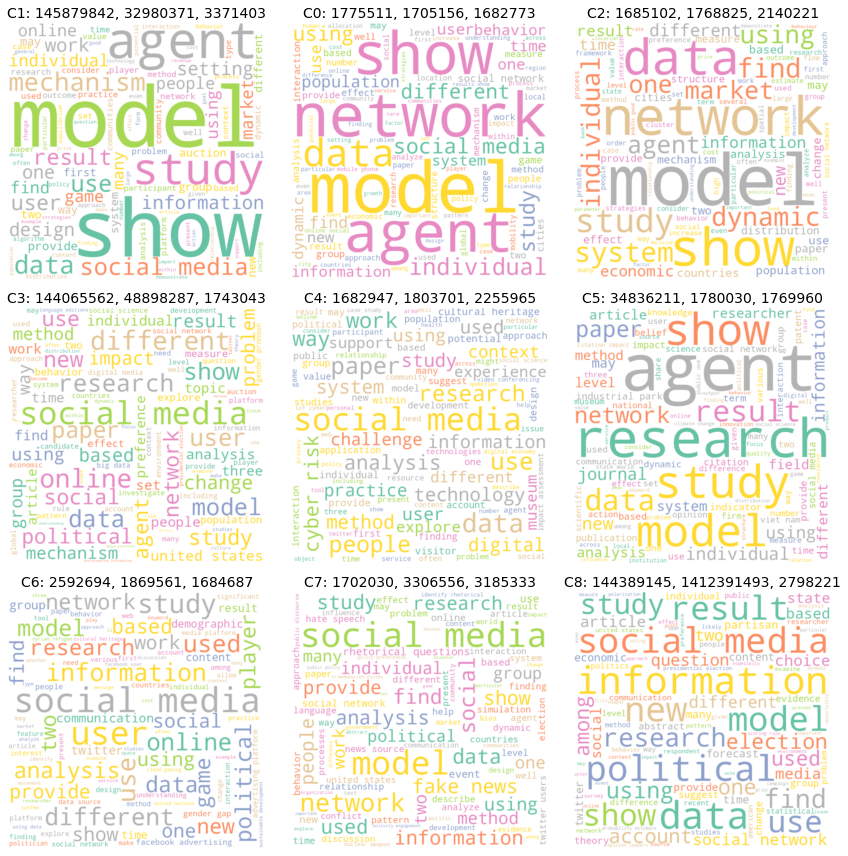

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(text_list):
        wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100, colormap='Set2').generate(text_list[i])
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'C{top_comm[i]}: {", ".join([str(i) for i in authors_list[i]])}', fontsize=14)
    else:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()


The following assumptions can be made about the different subcommunities based on the word clouds - 

* C0 - social networks and 'agents' heavily considered, data models used for analysis to understand user behaviour and structure of the social system.
* C1 - social media 'agents' heavily considered, data models and social media considered, word 'participant' and 'show' point towards social experiments as a data collection method.
* C2 - considers economics, markets, and social networks from a more 'individual' point of view and data and models are used to understand the dynamic systems.
* C3 - themes more spread out than 0,1, and 2; community studies social media and networks from a political, data, and digital point of view; considers 'impact' more often as well.
* C4 - themes more spread out than 0,1, and 2; more emphasis on cyber risk but has the same theme of social media, study of papers, and data and technology analysis.
* C5 - more research and results oriented; network and data models used; researchers and paper citations are also important.
* C6 - more policitical theme; themes in general more spread out than 0,1,2; games and players of some kind are also discussed.
* C7 - fake news and politics are important themes and twitter and elections are considered; usually social interactions and behaviors are considered to analyse people and conflicts.
* C8 - few, big themes present including politics, 'social media', 'study', 'research' 'data', 'models', and politics; social networks and twitter are also considered.


In [ ]:
temp = [authors_list[i][-1:][0] for i in range(9)]
print(f'List of most popular author ids for the 9 communities: {temp}')

List of most popular author ids for the 9 communities: [3371403, 1682773, 2140221, 1743043, 2255965, 1769960, 1684687, 3185333, 2798221]


Using the above list, the following authors are searched up.

* C1 - 3371403, J. Kleinberg - computer scientist, known for work in networking algo in large-scale social and information systems
* C0 - 1682772, A. Pentland - data scientist, co-led World Economic Forum, on the board of UN Foundations' Global Partnership for Sustainable Development Data
* C2 - 2140221, E. Zagheni - social demographer and professor known for his research on migration and population health
* C3 - 1743043, M. Strohmaier - Chair for Data-Science in the Economic and Social Sciences and Scientific Coordinator for Digital Behavioral Data at GESIS
* C4 - 2255965, S. Rintel - focuses on how the affordances and constraints of communication technologies interact with language, social action, and culture
* C5 - 1769960, A. Flammini - works include 'DARPA Twitter Bot Challenge', 'The Rise of Social Bots', and 'A Platform for Tracking Online Misinformation'.
* C6 - 1684687, Ingmar Weber - Research Director for Social Computing at the Qatar Computing Research Institute, curently works with monitoring international migration and digital gender gaps
* C7 - 3185333, D. Lazer - Co-Director, NULab for Texts, Maps, and Networks, among the leading scholars in the world on misinformation and computational social science
* C8 - 2798221, Saifuddin Ahmed -  'interested in the transformative role of new media in political engagement in technologically emerging societies', focuses on sociopolitical impact of algorithmic influence 

Comparing the results of the analysis from wordcloud and the analysis of the top authors, it can be seen that there are no big discrepencies between the work done by the author and the community the author belongs to. 

As the wordcloud uses TF statistic to rank its terms, it is not possible to see defining terms such as 'qatar' in C6 or 'presidential' in C8. However, the wordcloud was still able to capture the general themes. For example, the themes of 'politics' and 'fake news' were captured in C7 and C8 respectively. Also, while I. Weber from C6 does not seem as politically themed as her community is, the term 'gender gap' was present in the wordcloud for C6. As another example, A. Flammini is known for creating and analysing studies and platforms, which is representative of community C5. Lastly, it makes sense that A. Pentland is co-led the World Economic Forum as his community is economics and market centric.

In this way, the TF-IDF statistic and WordClouds can be used to understand themes and patterns in the computational social science communities.

## References
* Newman, M. E. (2003). Mixing patterns in networks. Physical review E, 67(2), 026126.